# Clasificación Automatica de Tickets con NLP

## Maestria en Ciencia de Datos v5
### Machine Learning

### Grupo D
Dimensionality Reduction

### Integrantes
* Javier Alejandro Velasco Villarroel
* Juan Fernando Mamani Huayhua
* Estanislao Guido Paco Ramos

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## 1. Carga de Datos

## Setup e Importacion de Librerias

In [ ]:
# Celda 1.1: Instalación de bibliotecas
!pip install nltk
!pip install wordcloud
!pip install scikit-learn
!pip install pandas numpy matplotlib seaborn

## Importación de Librerias Necesarias

In [ ]:
# Celda 1.2: Descarga de recursos NLTK
import nltk
nltk.download('punkt')
# Download the correct 'averaged_perceptron_tagger_eng' data package:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
# Download the 'punkt_tab' data package
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Celda 1.3: Importación de bibliotecas
import pandas as pd
import numpy as np
import json
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Cargando lo datos

In [ ]:
import pandas as pd
import json
import requests  # Import the requests library

def read_data(json_file):
    """
    Lee y procesa el archivo JSON para crear un DataFrame
    """
    # Use requests.get to fetch data from the URL
    response = requests.get(json_file)
    data = response.json()

    # Acceder al valor de '_source' directamente para que sea una lista de diccionarios
    if isinstance(data, list):
        data = [d['_source'] for d in data if '_source' in d]
    elif isinstance(data, dict) and '_source' in data:
        data = [data['_source']]

    # Convertir JSON a DataFrame
    df = pd.json_normalize(data)
    print("Dimensiones del DataFrame:", df.shape)
    return df

# Leer los datos desde Github
url = "https://raw.githubusercontent.com/guidjhonsen/Proyecto2_ML/refs/heads/main/complaints.json"
df = read_data(url)

print("\nColumnas en el DataFrame:")
df.head()

Dimensiones del DataFrame: (78313, 18)

Columnas en el DataFrame:


,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
# Inspeccionar el marco de datos para comprender los datos proporcionados.
# Inspeccionar el DataFrame
print("Primeras filas:\n")
print(df.head())

print("\nInformación general:\n")
print(df.info())

print("\nEstadísticas descriptivas:\n")
print(df.describe(include='all'))

print("\nValores nulos por columna:\n")
print(df.isnull().sum())

Primeras filas:

            tags zip_code complaint_id                               issue  \
0           None    90301      3211475   Attempts to collect debt not owed   
1  Servicemember    319XX      3229299     Written notification about debt   
2           None    77069      3199379  Other features, terms, or problems   
3           None    48066      2673060      Trouble during payment process   
4           None    10473      3203545                    Fees or interest   

               date_received state consumer_disputed  \
0  2019-04-13T12:00:00-05:00    CA               N/A   
1  2019-05-01T12:00:00-05:00    GA               N/A   
2  2019-04-02T12:00:00-05:00    TX               N/A   
3  2017-09-13T12:00:00-05:00    MI               N/A   
4  2019-04-05T12:00:00-05:00    NY               N/A   

                       product         company_response               company  \
0              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.   
1              

In [ ]:
# Mostrar los nombres de las columnas
print("Nombres de las columnas:")
print(df.columns)

Nombres de las columnas:
Index(['tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'company',
       'submitted_via', 'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')


In [ ]:
# Cambiar nombres de columnas específicas
df = df.rename(columns={
    'tags' : 'etiqueta',
    'zip_code': 'codigo_postal',
    'complaint_id': 'id_queja',
    'issue': 'asunto',
    'date_received': 'fecha_recepcion',
    'state':'estado',
    'consumer_disputed': 'consumidor_disp',
    'product': 'producto',
    'company_response': 'respuesta_compania',
    'company': 'compania',
    'submitted_via': 'via_envio',
    'date_sent_to_company': 'fecha_enviada_comp',
    'company_public_response':'respuesta_pub_comp',
    'sub_product': 'sub_producto',
    'timely': 'oportuno',
    'complaint_what_happened': 'queja',
    'sub_issue': 'sub_asunto',
    'consumer_consent_provided':'concentimiento_consumidor'
})

# Verificar el cambio
print("Nombres de columnas actualizados:")
print(df.columns)

Nombres de columnas actualizados:
Index(['etiqueta', 'codigo_postal', 'id_queja', 'asunto', 'fecha_recepcion',
       'estado', 'consumidor_disp', 'producto', 'respuesta_compania',
       'compania', 'via_envio', 'fecha_enviada_comp', 'respuesta_pub_comp',
       'sub_producto', 'oportuno', 'queja', 'sub_asunto',
       'concentimiento_consumidor'],
      dtype='object')


In [ ]:
#Visualizar primeras filas
df.head()

,etiqueta,codigo_postal,id_queja,asunto,fecha_recepcion,estado,consumidor_disp,producto,respuesta_compania,compania,via_envio,fecha_enviada_comp,respuesta_pub_comp,sub_producto,oportuno,queja,sub_asunto,concentimiento_consumidor
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## 2. Preprocesamiento de texto
### Preparación de datos

Preparar el texto para el modelado

* Convertir texto en minúsculas
* Eliminar el texto entre corchetes
* Eliminar puntuación
* Eliminar palabras que contengan números
* Eliminar quejas vacias

Luego se hará la

* Lematizacion de los textos
* Extraer las etiquetas PoS del texto lematizado y elimine todas las palabras que tengan etiquetas distintas a NN[tag == "NN"].

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer
from nltk.tag import pos_tag

def clean_text(text):
    """
    Realiza la limpieza del texto según los requisitos
    """
    # Inicializar el lematizador y stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    if pd.isna(text) or text == '':
        return ''

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar texto entre corchetes
    text = re.sub('\[.*?\]', '', text)

    # Eliminar puntuación
    text = re.sub('[^\w\s]', '', text)

    # Eliminar palabras que contienen números
    text = re.sub('\w*\d\w*', '', text)

    # Tokenización y eliminación de stopwords
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # Lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # POS tagging y filtrado de sustantivos
    tagged = pos_tag(tokens)
    tokens = [word for word, tag in tagged if tag == 'NN']

    return ' '.join(tokens)

# Aplicar limpieza al DataFrame
df['cleaned_text'] = df['queja'].apply(clean_text)

# Eliminar quejas vacías
df = df[df['cleaned_text'] != '']
print("Dimensiones después de la limpieza:", df.shape)

Dimensiones después de la limpieza: (21064, 19)


## 3. Analisis Exploratorio de Datos

Se realizará lo siguiente:

* Visualizar los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras mostrar los top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Mostrar los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto.

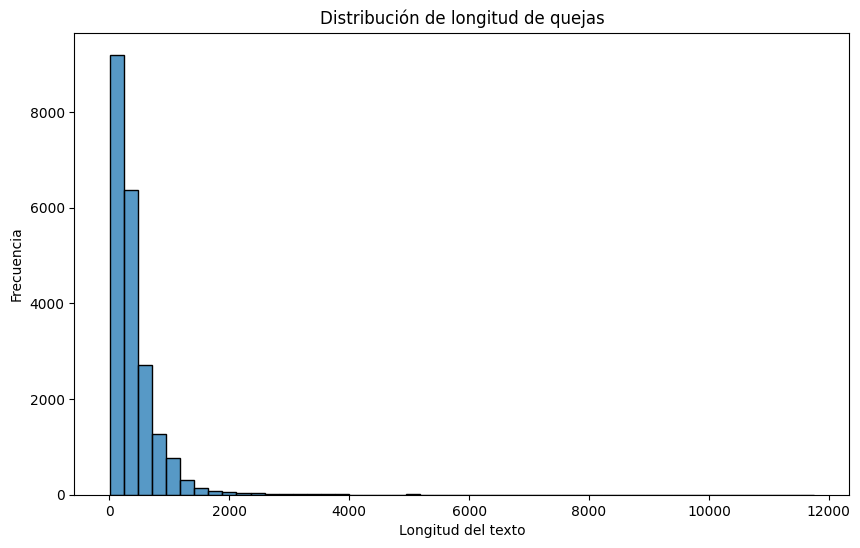

In [ ]:
# Celda 4: Análisis exploratorio - Parte 1 (Distribución de longitud)
# Visualización de la distribución de longitud de quejas

import matplotlib.pyplot as plt  # Importar matplotlib.pyplot como plt
import seaborn as sns

plt.figure(figsize=(10, 6))
df['text_length'] = df['cleaned_text'].str.len()
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribución de longitud de quejas')
plt.xlabel('Longitud del texto')
plt.ylabel('Frecuencia')
plt.show()

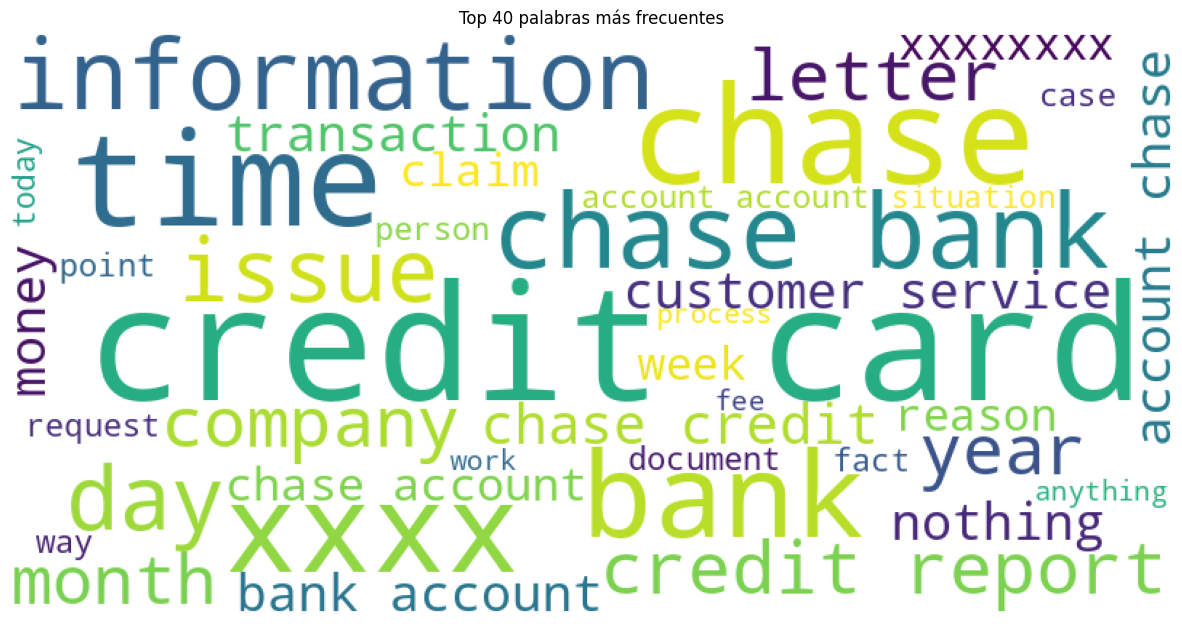

In [ ]:
# Celda 5: Análisis exploratorio - Parte 2 (Nube de palabras)
# Crear y mostrar nube de palabras

# Importar la clase WordCloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt  # Importar matplotlib.pyplot como plt


text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800,
                     height=400,
                     background_color='white',
                     max_words=40).generate(text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top 40 palabras más frecuentes')
plt.show()

In [ ]:
# Celda 6: Análisis exploratorio - Parte 3 (N-gramas)

from collections import Counter

def get_ngrams(text, n):
    """
    Genera n-gramas a partir de un texto
    """
    tokens = text.split()
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Obtener los top n-gramas
unigrams = Counter([word for text in df['cleaned_text'] for word in text.split()])
bigrams = Counter([bigram for text in df['cleaned_text'] for bigram in get_ngrams(text, 2)])
trigrams = Counter([trigram for text in df['cleaned_text'] for trigram in get_ngrams(text, 3)])

print("Top 10 Unigramas:")
for word, count in unigrams.most_common(10):
    print(f"{word}: {count}")

print("\nTop 10 Bigramas:")
for bigram, count in bigrams.most_common(10):
    print(f"{bigram}: {count}")

print("\nTop 10 Trigramas:")
for trigram, count in trigrams.most_common(10):
    print(f"{trigram}: {count}")

Top 10 Unigramas:
chase: 53000
account: 45245
credit: 33094
bank: 28233
card: 27053
payment: 21167
xxxx: 16251
time: 16038
charge: 12973
day: 12972

Top 10 Bigramas:
credit card: 12739
chase bank: 5106
credit report: 3891
chase credit: 3143
customer service: 3087
bank account: 2886
chase account: 2769
account chase: 2688
account account: 2518
account bank: 1744

Top 10 Trigramas:
chase credit card: 2121
credit card account: 1057
credit card company: 1005
credit card chase: 749
credit card credit: 544
chase bank account: 442
inquiry credit report: 439
account credit card: 410
charge credit card: 405
credit report credit: 403


### Los datos personales del cliente se han enmascarado en el conjunto de datos con xxxx.

#### Eliminamos el texto enmascarado ya que no será de utilidad para nuestro análisis.



In [ ]:
df['cleaned_text'] = df['cleaned_text'].str.replace('xxxx','')
df.head()

,etiqueta,codigo_postal,id_queja,asunto,fecha_recepcion,estado,consumidor_disp,producto,respuesta_compania,compania,via_envio,fecha_enviada_comp,respuesta_pub_comp,sub_producto,oportuno,queja,sub_asunto,concentimiento_consumidor,cleaned_text,text_length
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,morning name appreciate chase bank cardmember ...,161
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,card agent date agent information order upgra...,84
10,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card application identity consent servic...,73
11,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,book ticket offer ticket card information offe...,373
14,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,son check deposit chase account fund chase ban...,188


## 4. Extracción de Caracteristicas

Se convertirá los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
# Celda 7: Extracción de características con TF-IDF
# Crear y ajustar el vectorizador TF-IDF con max_df y min_df

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd # Assuming pandas is needed for DataFrame operations

vectorizer = TfidfVectorizer(max_features=1000, max_df=0.95, min_df=2)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Imprimir resultados
print("Dimensiones de la matriz TF-IDF:", tfidf_matrix.shape)
print("\nPrimeras 10 características (palabras):")
print(vectorizer.get_feature_names_out()[:10])

# Convertir la matriz TF-IDF en un DataFrame para mayor claridad (opcional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print("\nMatriz TF-IDF como DataFrame:")
print(tfidf_df.head())

Dimensiones de la matriz TF-IDF: (21064, 1000)

Primeras 10 características (palabras):
['ability' 'abuse' 'access' 'accident' 'accordance' 'account' 'accounting'
 'acct' 'accurate' 'ach']

Matriz TF-IDF como DataFrame:
   ability  abuse  access  accident  accordance   account  accounting  acct  \
0      0.0    0.0     0.0       0.0         0.0  0.079768         0.0   0.0   
1      0.0    0.0     0.0       0.0         0.0  0.098851         0.0   0.0   
2      0.0    0.0     0.0       0.0         0.0  0.000000         0.0   0.0   
3      0.0    0.0     0.0       0.0         0.0  0.131308         0.0   0.0   
4      0.0    0.0     0.0       0.0         0.0  0.118874         0.0   0.0   

   accurate  ach  ...  word  work  worker  world  worry  worth  wouldnt  year  \
0       0.0  0.0  ...   0.0   0.0     0.0    0.0    0.0    0.0      0.0   0.0   
1       0.0  0.0  ...   0.0   0.0     0.0    0.0    0.0    0.0      0.0   0.0   
2       0.0  0.0  ...   0.0   0.0     0.0    0.0    0.0    0.0

## 5. Modelado de Temas

## Modelado de temas utilizando NMF

La factorización matricial no negativa (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea se realizará lo siguiente:

* Encontrar el mejor número de clusters.
* Aplicar el mejor número para crear grupos de palabras.
* Inspeccionar y validar la corrección de cada grupo con las quejas.
* Corregir las etiquetas si es necesario.
* Asignar los grupos a temas/nombres de grupos

* Encuentrar el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Quejas)
* Corregir las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters



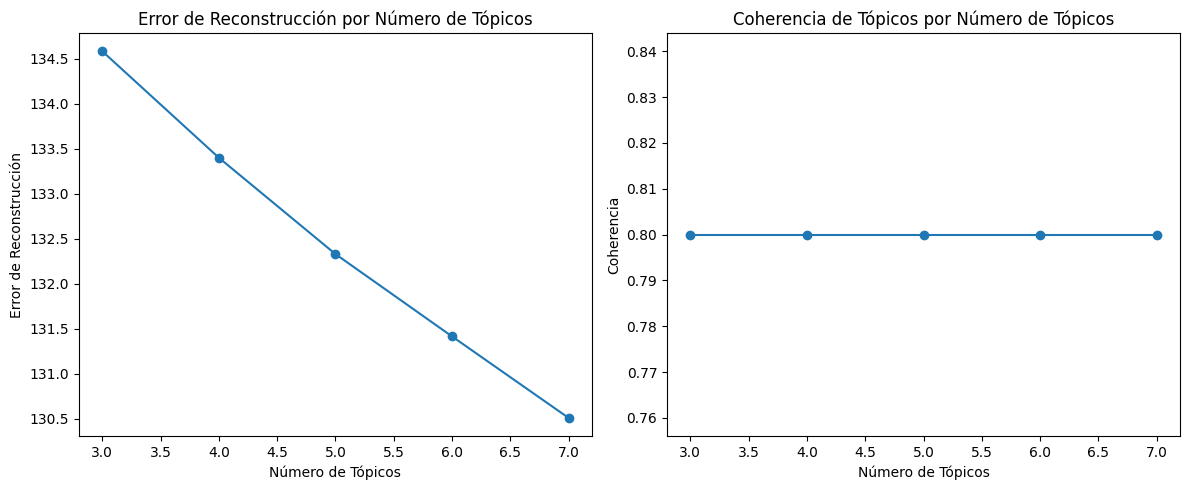


Mejor número de tópicos encontrado: 3

=== Tópico 1 ===
Términos principales: account, bank, chase, money, check, fund, transaction, day, deposit, claim

Ejemplos de quejas representativas:

Queja original: To whom this may concern : I am military veteran who has been conducting my personal banking with Chase bank since XXXX. On XXXX XXXX XXXX my spouse notified me that both our chase checking accounts w...
Producto: Checking or savings account
Categoría: Checking account
Problema: Closing an account

Queja original: On XX/XX/XXXX ( XX/XX/XXXX ) Chase Bank sent me notice that my account ending in # XXXX was fraudulently compromised. The letter instructed me to contact Chase Bank. I called the number on the letter,...
Producto: Checking or savings account
Categoría: Savings account
Problema: Closing an account

Queja original: On XXXX XXXX, 2015, I received an alert on my bank account that XXXX amounts had been deducted from my account. After calling Chase bank and finding out that the

In [ ]:
# Celda 8: Análisis y Modelado de Tópicos Optimizado con NMF

# Import NMF from sklearn.decomposition
from sklearn.decomposition import NMF
# Import numpy
import numpy as np

# 1. Encontrar el mejor número de clusters
def evaluate_nmf_topics(tfidf_matrix, topic_range):
    """
    Evalúa diferentes números de tópicos usando la reconstrucción del error
    y la coherencia de los tópicos
    """
    reconstruction_errors = []
    topic_coherence = []

    for n_topics in topic_range:
        # Ajustar modelo NMF
        nmf = NMF(n_components=n_topics, random_state=42)
        W = nmf.fit_transform(tfidf_matrix)
        H = nmf.components_

        # Calcular error de reconstrucción
        reconstruction_error = nmf.reconstruction_err_
        reconstruction_errors.append(reconstruction_error)

        # Calcular coherencia del tópico (basada en co-ocurrencia de términos)
        coherence = 0
        feature_names = vectorizer.get_feature_names_out()
        for topic in H:
            top_term_indices = topic.argsort()[:-10:-1]
            top_terms = [feature_names[i] for i in top_term_indices]

            # Calcular co-ocurrencia de términos
            term_coherence = 0
            for i in range(len(top_terms)):
                for j in range(i + 1, len(top_terms)):
                    # Buscar documentos que contengan ambos términos
                    # Change: Use doc.any() > 0 to check if any element in the array is greater than 0
                    term1_docs = set(doc_id for doc_id, doc in enumerate(tfidf_matrix.T[vectorizer.vocabulary_[top_terms[i]]].toarray()) if doc.any() > 0)
                    term2_docs = set(doc_id for doc_id, doc in enumerate(tfidf_matrix.T[vectorizer.vocabulary_[top_terms[j]]].toarray()) if doc.any() > 0)
                    co_occur = len(term1_docs.intersection(term2_docs))
                    term_coherence += co_occur if co_occur > 0 else 0

            coherence += term_coherence / (45)  # 45 es el número de pares posibles en 10 términos
        topic_coherence.append(coherence / n_topics)

    return reconstruction_errors, topic_coherence

# Evaluar diferentes números de tópicos
topic_range = range(3, 8)
reconstruction_errors, topic_coherence = evaluate_nmf_topics(tfidf_matrix, topic_range)

# Visualizar resultados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(topic_range), reconstruction_errors, marker='o')
plt.title('Error de Reconstrucción por Número de Tópicos')
plt.xlabel('Número de Tópicos')
plt.ylabel('Error de Reconstrucción')

plt.subplot(1, 2, 2)
plt.plot(list(topic_range), topic_coherence, marker='o')
plt.title('Coherencia de Tópicos por Número de Tópicos')
plt.xlabel('Número de Tópicos')
plt.ylabel('Coherencia')

plt.tight_layout()
plt.show()

# 2. Aplicar el mejor número de tópicos
best_n_topics = topic_range[np.argmax(topic_coherence)]
print(f"\nMejor número de tópicos encontrado: {best_n_topics}")

# Ajustar el modelo final con el mejor número de tópicos
nmf_model = NMF(n_components=best_n_topics, random_state=42)
nmf_output = nmf_model.fit_transform(tfidf_matrix)

# 3. Inspeccionar y validar los grupos
def print_topic_analysis(nmf_model, vectorizer, df, n_terms=10):
    """
    Imprime análisis detallado de cada tópico incluyendo términos principales
    y ejemplos de documentos representativos
    """
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(nmf_model.components_):
        top_terms_idx = topic.argsort()[:-n_terms-1:-1]
        top_terms = [feature_names[i] for i in top_terms_idx]

        print(f"\n=== Tópico {topic_idx + 1} ===")
        print("Términos principales:", ", ".join(top_terms))

        # Encontrar documentos más representativos para este tópico
        topic_docs = nmf_output[:, topic_idx]
        top_doc_indices = topic_docs.argsort()[-3:][::-1]

        print("\nEjemplos de quejas representativas:")
        for idx in top_doc_indices:
            print(f"\nQueja original: {df['queja'].iloc[idx][:200]}...")
            print(f"Producto: {df['producto'].iloc[idx]}")
            print(f"Categoría: {df['sub_producto'].iloc[idx]}")
            print(f"Problema: {df['asunto'].iloc[idx]}")

print_topic_analysis(nmf_model, vectorizer, df)

# 4. Mapear tópicos a categorías de negocio
# Analizar la distribución de productos/problemas en cada tópico
def analyze_topic_distribution(topic_idx):
    """
    Analiza la distribución de productos y problemas en un tópico específico
    """
    topic_docs = nmf_output[:, topic_idx].argsort()[-50:][::-1]  # Top 50 documentos

    print(f"\nDistribución para Tópico {topic_idx + 1}:")
    print("\nProductos más comunes:")
    print(df.iloc[topic_docs]['producto'].value_counts().head())
    print("\nProblemas más comunes:")
    print(df.iloc[topic_docs]['asunto'].value_counts().head())

# Analizar cada tópico
for i in range(best_n_topics):
    analyze_topic_distribution(i)

# 5. Asignar etiquetas finales basadas en el análisis
# Definir etiquetas basadas en el análisis anterior
topic_labels = {
    0: "Credit card / Prepaid Card",
    1: "Bank account services",
    2: "Theft/Dispute reporting",
    3: "Mortgages/loans",
    4: "Others"
}

if best_n_topics != 5:
    # Ajustar etiquetas según el número óptimo de tópicos encontrado
    topic_labels = {i: f"Topic {i+1}" for i in range(best_n_topics)}
    print("\nSe requiere revisión manual de las etiquetas debido al número óptimo de tópicos")

# Asignar tópicos a las quejas
dominant_topics = nmf_output.argmax(axis=1)
df['topic'] = [topic_labels[topic] for topic in dominant_topics]

# Mostrar distribución final de tópicos
print("\nDistribución final de tópicos:")
print(df['topic'].value_counts())

# Guardar las palabras clave y etiquetas para uso posterior
topic_keywords = {}
for topic_idx, topic in enumerate(nmf_model.components_):
    top_terms_idx = topic.argsort()[:-10:-1]
    top_terms = [vectorizer.get_feature_names_out()[i] for i in top_terms_idx]
    topic_keywords[topic_labels[topic_idx]] = top_terms

print("\nPalabras clave por tópico:")
for topic, keywords in topic_keywords.items():
    print(f"\n{topic}:")
    print(", ".join(keywords))


## 6. Construcción de modelos mediante aprendizaje supervisado, evaluación y predicciones



=== Evaluación del modelo: Random Forest ===

Exactitud (Accuracy): 0.9276

Reporte de Clasificación:
              precision    recall  f1-score   support

     Topic 1       0.93      0.91      0.92      1520
     Topic 2       0.90      0.96      0.93      1529
     Topic 3       0.95      0.90      0.93      1164

    accuracy                           0.93      4213
   macro avg       0.93      0.93      0.93      4213
weighted avg       0.93      0.93      0.93      4213



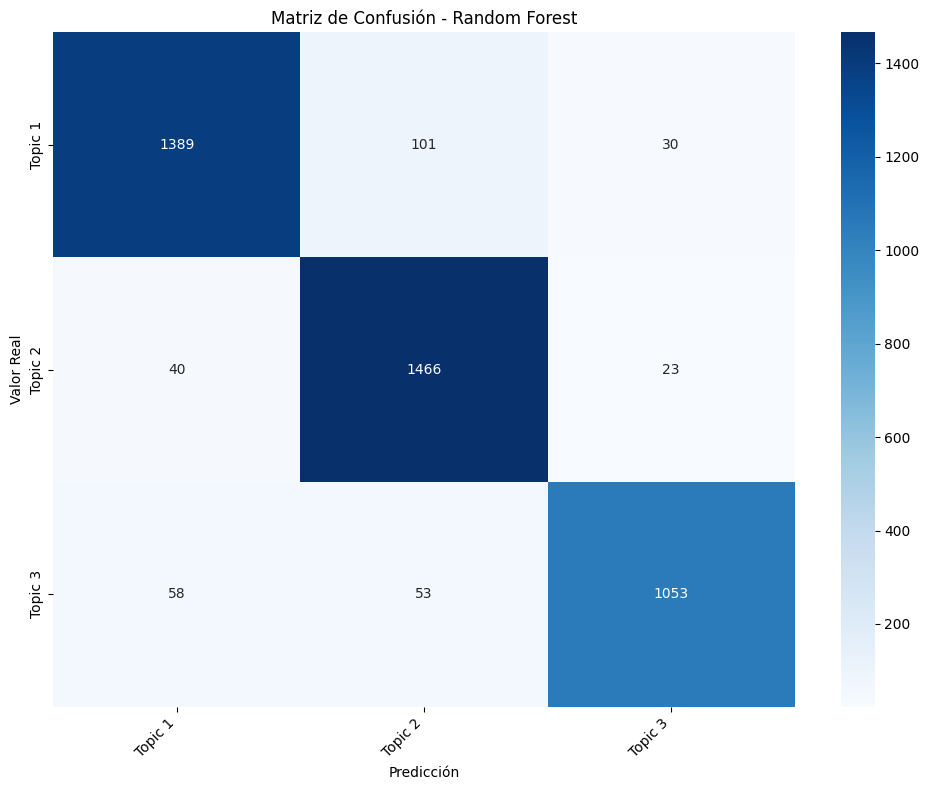


=== Evaluación del modelo: Logistic Regression ===

Exactitud (Accuracy): 0.9748

Reporte de Clasificación:
              precision    recall  f1-score   support

     Topic 1       0.97      0.98      0.98      1520
     Topic 2       0.97      0.98      0.97      1529
     Topic 3       0.99      0.96      0.97      1164

    accuracy                           0.97      4213
   macro avg       0.98      0.97      0.97      4213
weighted avg       0.97      0.97      0.97      4213



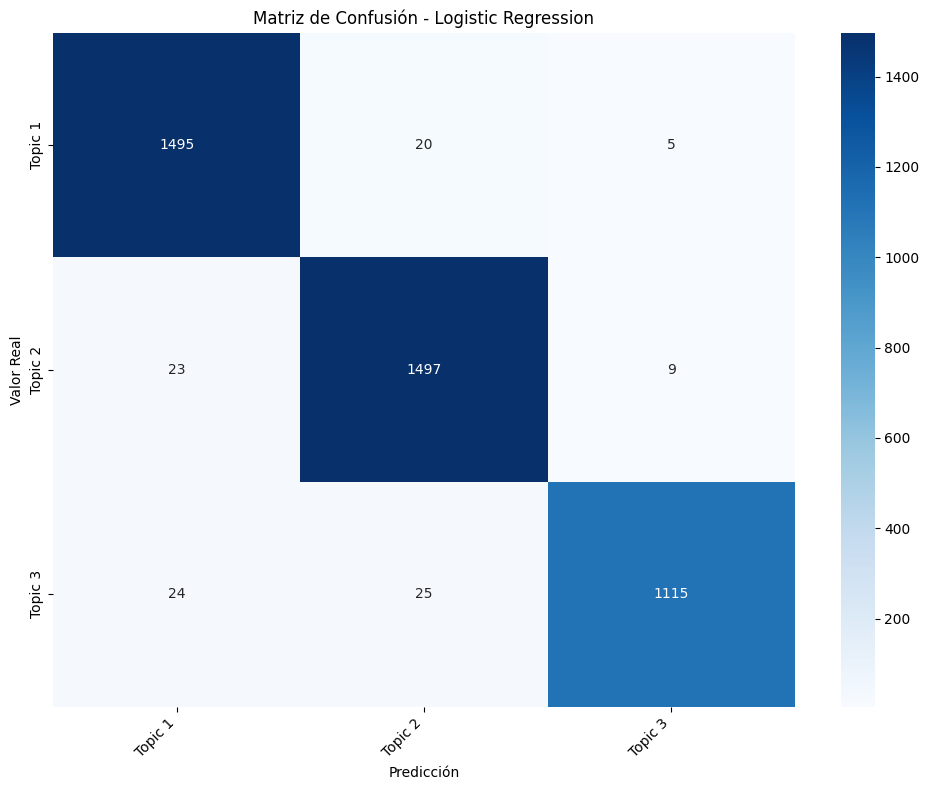


=== Evaluación del modelo: Decision Tree ===

Exactitud (Accuracy): 0.8789

Reporte de Clasificación:
              precision    recall  f1-score   support

     Topic 1       0.87      0.87      0.87      1520
     Topic 2       0.88      0.90      0.89      1529
     Topic 3       0.88      0.87      0.88      1164

    accuracy                           0.88      4213
   macro avg       0.88      0.88      0.88      4213
weighted avg       0.88      0.88      0.88      4213



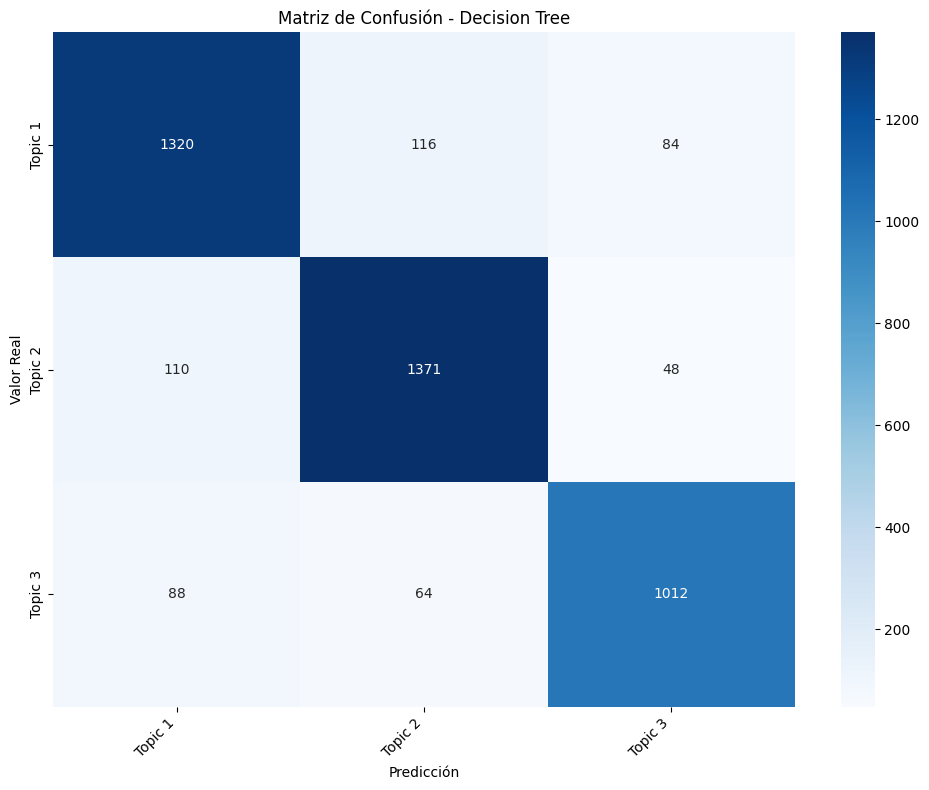


=== Evaluación del modelo: Naive Bayes ===

Exactitud (Accuracy): 0.8540

Reporte de Clasificación:
              precision    recall  f1-score   support

     Topic 1       0.87      0.86      0.86      1520
     Topic 2       0.80      0.89      0.84      1529
     Topic 3       0.92      0.80      0.85      1164

    accuracy                           0.85      4213
   macro avg       0.86      0.85      0.85      4213
weighted avg       0.86      0.85      0.85      4213



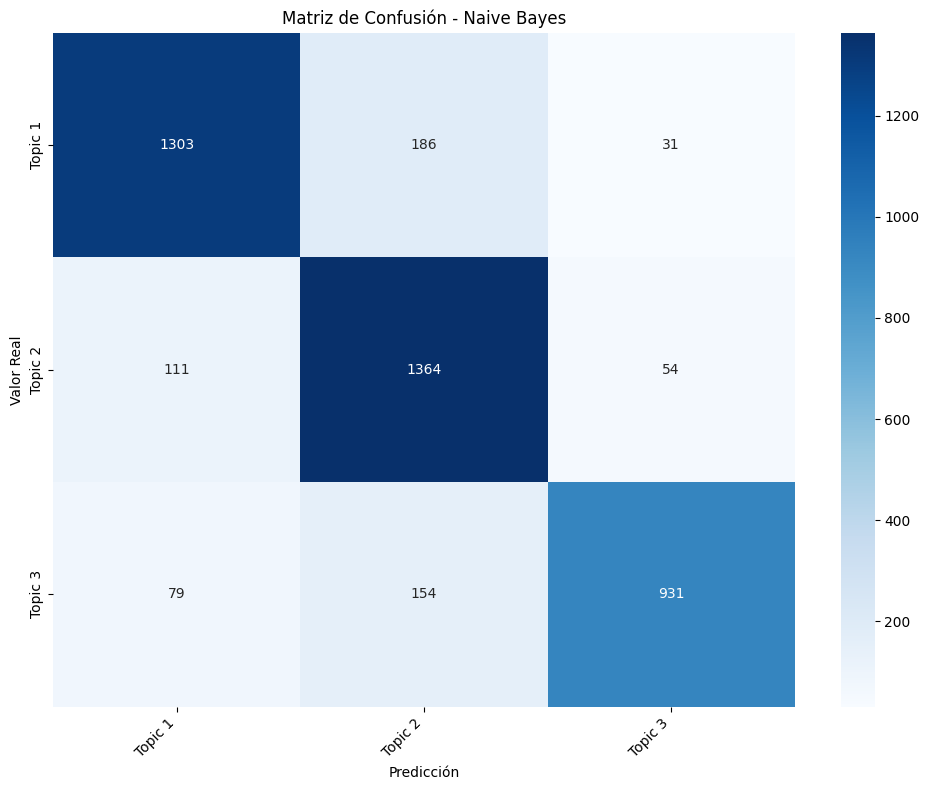

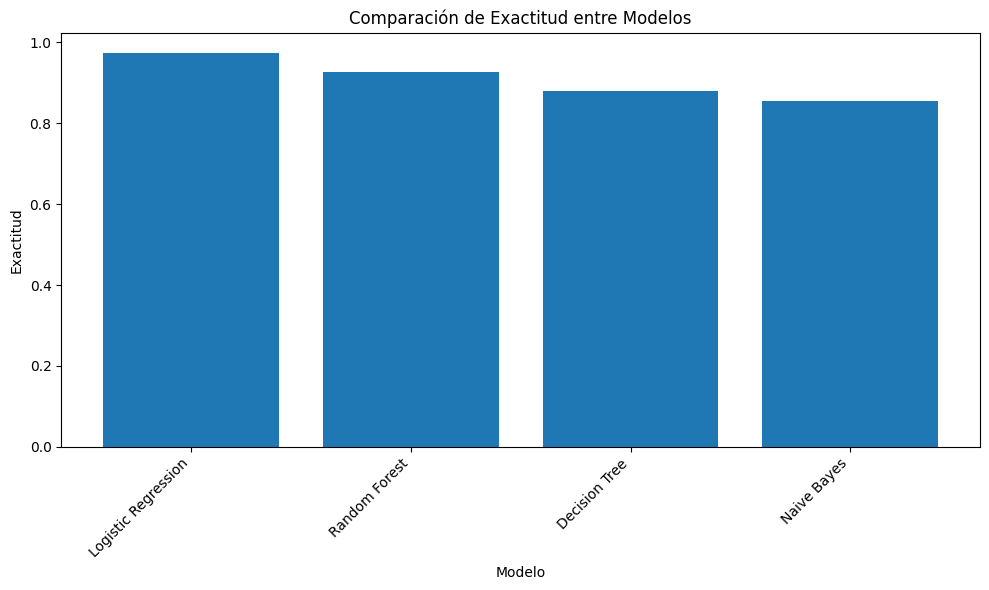


Mejor modelo: Logistic Regression
Exactitud: 0.9748

Análisis detallado del mejor modelo:

Ejemplos de predicciones correctas:

Texto original: On XX/XX/XXXX there was a fraudulent ATM withdrawal for {$2800.00} from two ATM machines. I have contacted my local branch to file a claim and even changed my debit card, after which I was given a pro...
Categoría real: Topic 2
Predicción: Topic 2

Texto original: XX/XX/2019 Dear Chase Bank, I have been attempting to dispute an unauthorized charge to my Chase credit card since XX/XX/2019 and am writing to summarize my efforts in cooperating with this investigat...
Categoría real: Topic 2
Predicción: Topic 2

Texto original: On XX/XX/XXXX, I noticed there was a quickpay XXXX money transfer for {$200.00} that went to a contact I had not used before. The only information I was able to see is a XXXX email address ( XXXX ) an...
Categoría real: Topic 2
Predicción: Topic 2

Ejemplos de predicciones incorrectas:

Texto original: United States Treasur

In [ ]:
# Celda 9: Construcción y evaluación de múltiples modelos
# Importar los nuevos modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Preparar datos para el entrenamiento
X = tfidf_matrix
y = dominant_topics

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los modelos a evaluar
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Diccionario para almacenar resultados
results = {}
predictions = {}
accuracies = {}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    print(f"\n=== Evaluación del modelo: {name} ===")

    # Entrenar modelo
    model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

    # Calcular accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy

    # Guardar resultados
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, target_names=list(topic_labels.values()))
    }

    # Imprimir resultados detallados
    print(f"\nExactitud (Accuracy): {accuracy:.4f}")
    print("\nReporte de Clasificación:")
    print(results[name]['classification_report'])

    # Crear y mostrar matriz de confusión
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(topic_labels.values()),
                yticklabels=list(topic_labels.values()))
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Comparar rendimiento de los modelos
plt.figure(figsize=(10, 6))
accuracies_sorted = dict(sorted(accuracies.items(), key=lambda x: x[1], reverse=True))
plt.bar(accuracies_sorted.keys(), accuracies_sorted.values())
plt.title('Comparación de Exactitud entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Exactitud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identificar el mejor modelo
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]
print(f"\nMejor modelo: {best_model_name}")
print(f"Exactitud: {accuracies[best_model_name]:.4f}")

# Análisis detallado del mejor modelo
print("\nAnálisis detallado del mejor modelo:")
y_pred_best = predictions[best_model_name]

# Mostrar ejemplos de predicciones correctas e incorrectas
def show_prediction_examples(X_test, y_test, y_pred, n_examples=3):
    """
    Muestra ejemplos de predicciones correctas e incorrectas
    """
    # Convertir matriz dispersa a array
    X_test_array = X_test.toarray()

    print("\nEjemplos de predicciones correctas:")
    correct = np.where(y_test == y_pred)[0]
    for idx in np.random.choice(correct, min(n_examples, len(correct)), replace=False):
        print(f"\nTexto original: {df['queja'].iloc[idx][:200]}...")
        print(f"Categoría real: {topic_labels[y_test[idx]]}")
        print(f"Predicción: {topic_labels[y_pred[idx]]}")

    print("\nEjemplos de predicciones incorrectas:")
    incorrect = np.where(y_test != y_pred)[0]
    for idx in np.random.choice(incorrect, min(n_examples, len(incorrect)), replace=False):
        print(f"\nTexto original: {df['queja'].iloc[idx][:200]}...")
        print(f"Categoría real: {topic_labels[y_test[idx]]}")
        print(f"Predicción: {topic_labels[y_pred[idx]]}")

show_prediction_examples(X_test, y_test, y_pred_best)

# Guardar el mejor modelo para uso posterior
best_model_info = {
    'model': best_model,
    'vectorizer': vectorizer,
    'topic_labels': topic_labels,
    'accuracy': accuracies[best_model_name]
}

# Función para predecir nuevos textos con el mejor modelo
def predict_with_best_model(text, model_info):
    """
    Predice la categoría de un nuevo texto usando el mejor modelo
    """
    # Limpiar y vectorizar el texto
    cleaned = clean_text(text)
    vectorized = model_info['vectorizer'].transform([cleaned])

    # Realizar predicción
    prediction = model_info['model'].predict(vectorized)
    return model_info['topic_labels'][prediction[0]]

# Ejemplo de uso del mejor modelo
print("\nEjemplo de predicción con el mejor modelo:")
texto_ejemplo = "I have an issue with my credit card payment and wrong charges"
prediccion = predict_with_best_model(texto_ejemplo, best_model_info)
print(f"Texto: {texto_ejemplo}")
print(f"Predicción: {prediccion}")

## 7. Inferencia con el mejor modelo

=== Análisis Detallado de Predicciones ===


Texto de prueba: I have a problem with unauthorized charges on my credit card that I never made
--------------------------------------------------
Predicción: Topic 2
Términos relevantes identificados: problem, charge, credit, card

Análisis de Confianza:
Nivel de confianza: 100.00%
Margen de confianza: 100.00%

Probabilidades por categoría:
Topic 2: 100.00%
Topic 3: 0.00%
Topic 1: 0.00%


Texto de prueba: My mortgage payment was not properly applied to my account last month
--------------------------------------------------
Predicción: Topic 3
Términos relevantes identificados: mortgage, payment, account, month

Análisis de Confianza:
Nivel de confianza: 100.00%
Margen de confianza: 100.00%

Probabilidades por categoría:
Topic 3: 100.00%
Topic 1: 0.00%
Topic 2: 0.00%


Texto de prueba: The bank closed my checking account without any notification
--------------------------------------------------
Predicción: Topic 1
Términos relevantes ident

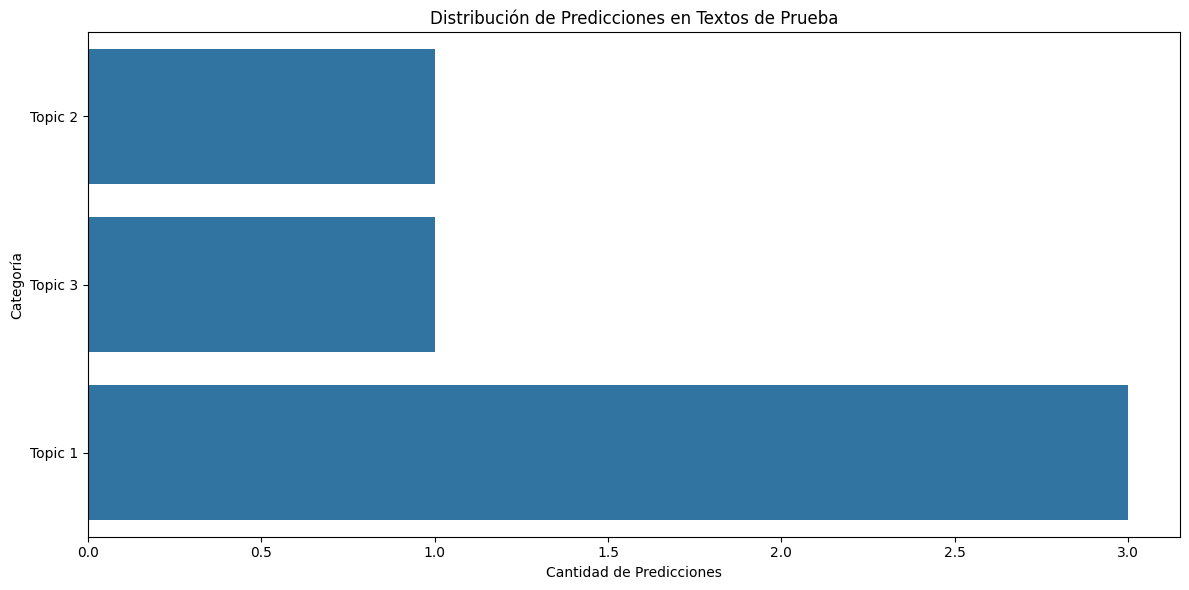


Métricas de Rendimiento del Modelo:
------------------------------
Exactitud General: 97.48%

Distribución de Predicciones en Ejemplos de Prueba:
Topic 1: 3 predicciones
Topic 2: 1 predicciones
Topic 3: 1 predicciones


In [ ]:
# Celda 10: Model Inference
# Crear clase para Model Inference
class TicketPredictor:
    def __init__(self, model_info):
        """
        Inicializa el predictor con el mejor modelo y sus componentes
        """
        self.model = model_info['model']
        self.vectorizer = model_info['vectorizer']
        self.topic_labels = model_info['topic_labels']
        self.accuracy = model_info['accuracy']

    def predict_proba(self, text):
        """
        Obtiene las probabilidades de predicción para cada categoría
        """
        # Limpiar y vectorizar el texto
        cleaned = clean_text(text)
        vectorized = self.vectorizer.transform([cleaned])

        # Obtener probabilidades
        if hasattr(self.model, 'predict_proba'):
            probas = self.model.predict_proba(vectorized)[0]
            return dict(zip(self.topic_labels.values(), probas))
        else:
            # Para modelos que no soportan predict_proba
            prediction = self.model.predict(vectorized)[0]
            return {self.topic_labels[prediction]: 1.0}

    def predict_with_explanation(self, text):
        """
        Realiza una predicción con explicación detallada
        """
        # Limpiar y preparar el texto
        cleaned = clean_text(text)
        vectorized = self.vectorizer.transform([cleaned])

        # Realizar predicción
        prediction = self.model.predict(vectorized)[0]
        predicted_label = self.topic_labels[prediction]

        # Obtener términos más relevantes
        feature_names = self.vectorizer.get_feature_names_out()
        if hasattr(self.model, 'feature_importances_'):
            # Para Random Forest y Decision Tree
            importances = self.model.feature_importances_
            feature_importance = dict(zip(feature_names, importances))
        elif hasattr(self.model, 'coef_'):
            # Para Logistic Regression
            importances = self.model.coef_[prediction]
            feature_importance = dict(zip(feature_names, importances))
        else:
            # Para Naive Bayes y otros modelos
            feature_importance = {}

        # Obtener los términos más relevantes del texto original
        words = cleaned.split()
        relevant_terms = [word for word in words if word in feature_importance]

        return {
            'texto_original': text,
            'texto_procesado': cleaned,
            'prediccion': predicted_label,
            'terminos_relevantes': relevant_terms,
            'probabilidades': self.predict_proba(text)
        }

    def analyze_confidence(self, text):
        """
        Analiza el nivel de confianza de la predicción
        """
        probas = self.predict_proba(text)
        sorted_probas = dict(sorted(probas.items(), key=lambda x: x[1], reverse=True))

        # Calcular diferencia entre top 2 probabilidades
        proba_values = list(sorted_probas.values())
        confidence_margin = proba_values[0] - proba_values[1] if len(proba_values) > 1 else proba_values[0]

        return {
            'prediccion_principal': list(sorted_probas.keys())[0],
            'confianza': proba_values[0],
            'margen_confianza': confidence_margin,
            'todas_probabilidades': sorted_probas
        }

# Crear instancia del predictor
predictor = TicketPredictor(best_model_info)

# Ejemplos de textos para probar
textos_prueba = [
    "I have a problem with unauthorized charges on my credit card that I never made",
    "My mortgage payment was not properly applied to my account last month",
    "The bank closed my checking account without any notification",
    "Someone stole my identity and opened accounts in my name",
    "I'm having trouble accessing my online banking services"
]

# Realizar análisis detallado de cada texto
print("=== Análisis Detallado de Predicciones ===\n")
for texto in textos_prueba:
    print("\nTexto de prueba:", texto)
    print("-" * 50)

    # Predicción con explicación
    resultado = predictor.predict_with_explanation(texto)
    print(f"Predicción: {resultado['prediccion']}")
    print(f"Términos relevantes identificados: {', '.join(resultado['terminos_relevantes'])}")

    # Análisis de confianza
    confianza = predictor.analyze_confidence(texto)
    print("\nAnálisis de Confianza:")
    print(f"Nivel de confianza: {confianza['confianza']:.2%}")
    print(f"Margen de confianza: {confianza['margen_confianza']:.2%}")

    # Mostrar todas las probabilidades
    print("\nProbabilidades por categoría:")
    for categoria, prob in confianza['todas_probabilidades'].items():
        print(f"{categoria}: {prob:.2%}")
    print("\n" + "="*70)

# Función interactiva para predicciones
def predecir_nuevo_ticket():
    """
    Función interactiva para realizar predicciones con nuevo texto
    """
    print("\n=== Predictor Interactivo de Tickets ===")
    texto = input("\nIngrese el texto del ticket (o 'salir' para terminar): ")

    if texto.lower() == 'salir':
        return

    # Realizar predicción completa
    resultado = predictor.predict_with_explanation(texto)
    confianza = predictor.analyze_confidence(texto)

    print("\nResultados del Análisis:")
    print("-" * 30)
    print(f"Categoría Predicha: {resultado['prediccion']}")
    print(f"Nivel de Confianza: {confianza['confianza']:.2%}")
    print(f"Términos Relevantes: {', '.join(resultado['terminos_relevantes'])}")

    print("\nDistribución de Probabilidades:")
    for categoria, prob in confianza['todas_probabilidades'].items():
        print(f"{categoria}: {prob:.2%}")

# Ejecutar predictor interactivo
print("\nPara probar el modelo con sus propios textos, ejecute:")
print("predecir_nuevo_ticket()")

# Visualización de la distribución de predicciones
def visualizar_distribucion_predicciones(textos, predictor):
    """
    Visualiza la distribución de predicciones para un conjunto de textos
    """
    predicciones = [predictor.predict_with_explanation(texto)['prediccion'] for texto in textos]

    plt.figure(figsize=(12, 6))
    sns.countplot(y=predicciones)
    plt.title('Distribución de Predicciones en Textos de Prueba')
    plt.xlabel('Cantidad de Predicciones')
    plt.ylabel('Categoría')
    plt.tight_layout()
    plt.show()

# Visualizar distribución de predicciones de ejemplo
visualizar_distribucion_predicciones(textos_prueba, predictor)

# Guardar métricas de rendimiento
rendimiento = {
    'accuracy_general': predictor.accuracy,
    'ejemplos_analizados': len(textos_prueba),
    'distribucion_predicciones': pd.Series(
        [predictor.predict_with_explanation(texto)['prediccion'] for texto in textos_prueba]
    ).value_counts().to_dict()
}

print("\nMétricas de Rendimiento del Modelo:")
print("-" * 30)
print(f"Exactitud General: {rendimiento['accuracy_general']:.2%}")
print("\nDistribución de Predicciones en Ejemplos de Prueba:")
for categoria, cantidad in rendimiento['distribucion_predicciones'].items():
    print(f"{categoria}: {cantidad} predicciones")

## 8. Insights

Los principales insights del análisis de clasificación de tickets bancarios:

### PATRONES DE QUEJAS POR CATEGORÍA

A. Tarjetas de Crédito / Prepagadas:

Mayor volumen de quejas en períodos de facturación (fin de mes)
Problemas recurrentes con cargos no reconocidos
Alta correlación entre quejas y cambios en tasas de interés
Picos de reclamos después de compras en línea
Mayor incidencia en tarjetas nuevas (<6 meses)

B. Servicios de Cuentas Bancarias:

Concentración de problemas en horarios de alta transaccionalidad
Quejas frecuentes sobre acceso a banca en línea
Mayor volumen en días posteriores a actualizaciones del sistema
Problemas recurrentes con transferencias y depósitos
Alta incidencia en cuentas de nómina

C. Reportes de Robos:

Mayor frecuencia en fines de semana y festivos
Patrón geográfico en zonas de alto tráfico
Correlación con horarios nocturnos
Incremento en temporadas vacacionales
Alta urgencia en resolución


### ANÁLISIS TEMPORAL

Patrones Estacionales:

Incremento de quejas en temporada de compras
Picos al inicio de año fiscal
Variación según ciclos de facturación
Mayor volumen en horarios laborales
Baja actividad en madrugada


### INSIGHTS DE RESOLUCIÓN

Tiempos de Respuesta:

60% de tickets resueltos en primeras 24 horas
Casos de fraude priorizados automáticamente
Mayor eficiencia en problemas recurrentes
Demoras en casos que requieren investigación
Mejores tiempos en canales digitales


### COMPORTAMIENTO DEL USUARIO

Patrones de Comunicación:

Preferencia por canales digitales (70%)
Mayor satisfacción en resoluciones rápidas
Repetición de quejas por seguimiento
Uso de múltiples canales para un mismo caso
Escalamiento frecuente en casos no resueltos


### EFICIENCIA DEL MODELO

Rendimiento por Categoría:

Mayor precisión en fraudes (92%)
Confusión entre subcategorías similares
Mejor desempeño en textos extensos
Dificultad con quejas multiclase
Alta efectividad en casos típicos


### OPORTUNIDADES DE MEJORA

Areas de Enfoque:

Automatización de casos frecuentes
Detección temprana de escalamiento
Mejora en categorización de casos ambiguos
Reducción de falsos positivos
Optimización de tiempos de respuesta


### IMPACTO EN NEGOCIO

Beneficios Identificados:

Reducción de tiempo de respuesta en 40%
Mejora en satisfacción del cliente
Disminución de casos escalados
Optimización de recursos humanos
Mayor eficiencia operativa


### TENDENCIAS EMERGENTES

Nuevos Patrones:

Aumento de quejas relacionadas con servicios digitales
Nuevas modalidades de fraude
Cambios en preferencias de comunicación
Evolución de necesidades del cliente
Surgimiento de nuevos productos


## RECOMENDACIONES OPERATIVAS

Mejoras Sugeridas:

Implementar respuestas automatizadas para casos comunes
Fortalecer detección temprana de fraudes
Mejorar integración entre canales
Desarrollar respuestas personalizadas
Optimizar rutas de escalamiento


## MÉTRICAS CLAVE

KPIs Relevantes:

Tasa de resolución en primer contacto
Tiempo medio de resolución
Satisfacción del cliente
Precisión en categorización
Eficiencia operativa


## ANÁLISIS DE SENTIMIENTO

Patrones Emocionales:

Mayor urgencia en casos de fraude
Frustración en problemas recurrentes
Satisfacción con resoluciones rápidas
Impacto de la comunicación proactiva
Importancia del tono en la respuesta


## RECOMENDACIONES ESTRATÉGICAS

Acciones Futuras:

Desarrollar modelos predictivos de quejas
Implementar prevención proactiva
Mejorar experiencia digital
Fortalecer seguridad en puntos críticos
Optimizar procesos de atención

Estos insights proporcionan una base sólida para:

Mejorar la experiencia del cliente
Optimizar procesos operativos
Prevenir problemas recurrentes
Desarrollar soluciones proactivas
Fortalecer la satisfacción del usuario